In [31]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account

# from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [32]:
print(tf.__version__)

2.11.0


In [33]:
#table_id='test_incident'
# table_id='validation_incident'
table_id='new_incident'

isLocalModel=True
isBQToCSV=True
localMapFile=True
bucketName="smart-ml-pongthorn"


modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

# projectId='smart-data-ml'
projectId='pongthorn'
dataset_id='SMartML'
REGION="asia-southeast1"


# mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
bqclient= bigquery.Client(project=projectId)

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='../../data/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'../../data/Prediction_{table_id}.csv'


In [34]:
if isBQToCSV:
    
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         37 non-null     Int64         
 1   severity_id                37 non-null     Int64         
 2   severity_name              37 non-null     object        
 3   sla                        37 non-null     object        
 4   product_type               37 non-null     object        
 5   brand                      37 non-null     object        
 6   service_type               37 non-null     object        
 7   incident_type              37 non-null     object        
 8   open_to_close_hour         37 non-null     float64       
 9   response_to_resolved_hour  37 non-null     float64       
 10  imported_at                37 non-null     datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), float64(2), object(6)
memory usage: 3.4+ 


# Load and Map Data Test

In [35]:

mapping_file="incident_severity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket(bucketName)
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localMapFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)



{'Cosmetic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [36]:
if  table_id=='new_incident':
   dfNewData['severity']= dfNewData['severity_name'].map(map_sevirity_to_class)
else:
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_binary_severity'])

if 'id' not in dfNewData.columns.to_list():
    dfNewData=dfNewData.reset_index(drop=True)
    dfNewData = dfNewData.reset_index(level=0)
    dfNewData.rename(columns={"index": "id"},inplace=True)
    dfNewData['id']=dfNewData['id']+1
print(f"Table: {table_id}")
print(filePath) 
print(dfNewData.info())
dfNewData.sample(10)

Table: new_incident
../../data/Prediction_New_Incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         37 non-null     Int64         
 1   severity_id                37 non-null     Int64         
 2   severity_name              37 non-null     object        
 3   sla                        37 non-null     object        
 4   product_type               37 non-null     object        
 5   brand                      37 non-null     object        
 6   service_type               37 non-null     object        
 7   incident_type              37 non-null     object        
 8   open_to_close_hour         37 non-null     float64       
 9   response_to_resolved_hour  37 non-null     float64       
 10  imported_at                37 non-null     datetime64[ns]
 11  severity      

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,imported_at,severity
31,3172,4,Cosmetic,24x7 4Hrs Resolution Time,Access Point,Cisco,Request,General Incident,4.500000,0.500000,2023-07-19 18:44:44.442858,0
8,3193,2,Major,24x7 4Hrs Resolution Time,Storage,Oracle,Incident,Memory Failure,2186.000000,2.000000,2023-07-19 18:44:44.442858,2
1,3171,2,Major,24x7 4Hrs Response Time,Server,HPE,Incident,System Board Failure,59.266667,58.600000,2023-07-19 18:44:44.442858,2
24,3179,3,Minor,24x7 4Hrs Resolution Time,Software,VMWare,Incident,Software,2.000000,1.983333,2023-07-19 18:44:44.442858,1
33,3173,4,Cosmetic,24x7 4Hrs Resolution Time,Software,Veeam,Request,Software,2.000000,1.983333,2023-07-19 18:44:44.442858,0
29,2409,4,Cosmetic,24x7 4Hrs Response Time,Storage,NetApp,Request,OS / Firmware,3060.216667,3055.483333,2023-07-19 18:44:44.442858,0
22,3181,3,Minor,24x7 4Hrs Resolution Time,Software,VMWare,Incident,Software,1.483333,1.466667,2023-07-19 18:44:44.442858,1
14,3198,2,Major,24x7 6Hrs Resolution Time,Software,YIP,Incident,General Incident,1.600000,1.333333,2023-07-19 18:44:44.442858,2
7,3063,2,Major,24x7 4Hrs Resolution Time,Server,Oracle,Incident,OS / Firmware,1374.533333,1374.533333,2023-07-19 18:44:44.442858,2
17,3187,3,Minor,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,23.400000,23.400000,2023-07-19 18:44:44.442858,1


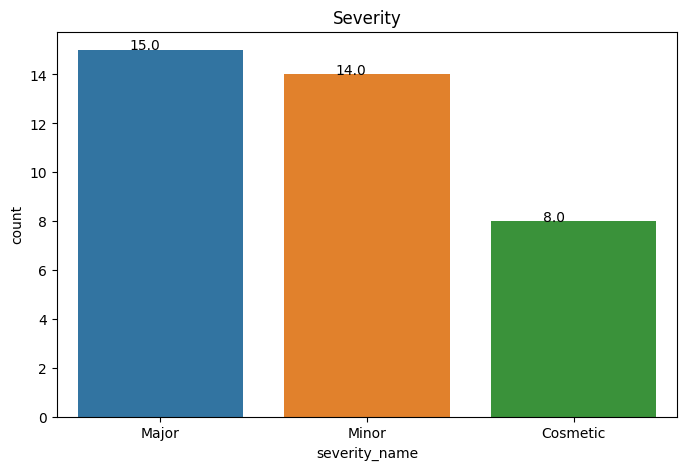

In [37]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [38]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [39]:
if modelFile_endPoint==1 :

    if  isLocalModel: # Window Enviroment
        PATH_FOLDER_ARTIFACTS="model"    
    else: # For running on Vertex AI Notebook t
        PATH_FOLDER_ARTIFACTS="gs://tf1-incident-pongthorn/model"

    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)
          # print(f"{predictionResult}")   
          # maxResult=np.max(arryResult)
          # maxResult=round( maxResult,4)
          # print(f"{maxResult} of {arryResult}")

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from model
2856 - 2(Major)
1/1 [==============================] - 0s 402ms/step
[[19.637575 34.845596 26.444561 19.072266]] %   as 1
3171 - 2(Major)
1/1 [==============================] - 0s 66ms/step
[[18.13206 18.62625 43.99404 19.24765]] %   as 2
3161 - 2(Major)
1/1 [==============================] - 0s 44ms/step
[[18.755678 22.347052 38.948624 19.948639]] %   as 2
3168 - 2(Major)
1/1 [==============================] - 0s 49ms/step
[[17.588661 17.799095 47.013786 17.598448]] %   as 2
3182 - 2(Major)
1/1 [==============================] - 0s 50ms/step
[[19.331732 31.580559 28.617033 20.470676]] %   as 1
3176 - 2(Major)
1/1 [==============================] - 0s 54ms/step
[[18.105858 20.466568 43.20734  18.220238]] %   as 2
3048 - 2(Major)
1/1 [==============================] - 0s 40ms/step
[[18.43217  22.306318 40.471222 18.79028 ]] %   as 2
3063 - 2(Major)
1/1 [==============================] - 0s 54ms/step
[[17.977005 19.02646  44.779037 18.217485]] %   as 2
3193 - 2(Major)
1/1

# Registry and Deploy Model to VertextAI
- https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#deploy_a_model_to_an_endpoint


## Load Model from Online EndPpint to Predict
- https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/train-and-deploy-model
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/make-prediction

In [40]:
#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#https://console.cloud.google.com/vertex-ai/batch-predictions?project=pongthorn


# MODEL_ID="2102389377610022912"
# MODEL_URI =  f'projects/{PROJECT_NUMBER}/locations/{REGION}/models/{MODEL_ID}'
# print(MODEL_URI)

# model = aiplatform.Model(MODEL_URI)

# Load model by refering to vertext-ai registry

In [41]:
# instances = []
# dfX=dfNewData.drop(columns=unUsedColtoPredict)
# for index,row in dfX.iterrows():
#     dict_item=row.to_dict()
#     instance = {}
#     for key, value in dict_item.items():
#         if key in unUsedColtoPredict:
#             continue
#         if value is None:
#             value = ""
#         instance[key] = [value]
#         # instance[key] = value
#     instances.append(instance)

# print(len(instances))
# print(instances[0])

In [42]:
isEndpointAvaiable=False

listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
                                   ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

name 'aiplatform' is not defined
No endpoint to predict  as online predction


# Classification Rerport

In [43]:
from sklearn.metrics import confusion_matrix,classification_report


In [44]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,2856,1,2,Major
1,3171,2,2,Major
2,3161,2,2,Major
3,3168,2,2,Major
4,3182,1,2,Major
5,3176,2,2,Major
6,3048,2,2,Major
7,3063,2,2,Major
8,3193,2,2,Major
9,3148,2,2,Major


In [45]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2
actual-0,5,3,0
actual-1,0,5,9
actual-2,0,4,11


In [46]:
print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.42      0.36      0.38        14
           2       0.55      0.73      0.63        15

    accuracy                           0.57        37
   macro avg       0.66      0.57      0.59        37
weighted avg       0.60      0.57      0.57        37

